<a href="https://colab.research.google.com/github/umji4500/Master-Thesis/blob/main/Energy_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🚀 Initializing Final 1-Day Efficiency Score Simulation (Corrected Model)...
  - Defining dynamic energy consumption model...
  - Defining energy generation model...

Processing orbit: SSO...

Processing orbit: NSSO-1d-45...

Processing orbit: NSSO-1d-50...

Processing orbit: NSSO-1d-60...

Processing orbit: NSSO-1d-70...

Processing orbit: NSSO-1d-110...

--- Final Efficiency Score Analysis (1-Day Simulation) ---
Final Ranked Orbits by Efficiency Score:
         Orbit  total_strips_captured  total_visible_duration  net_energy_balance_kJ  strips_per_kJ  visibility_score  energy_score  efficiency_score
0   NSSO-1d-70                    519                    1040                9588.89           0.02          0.290455      0.815378          0.552917
1   NSSO-1d-60                    513                    1028                7923.41           0.02          0.496320      0.554072          0.525196
2          SSO                    331                     663               10765.61        

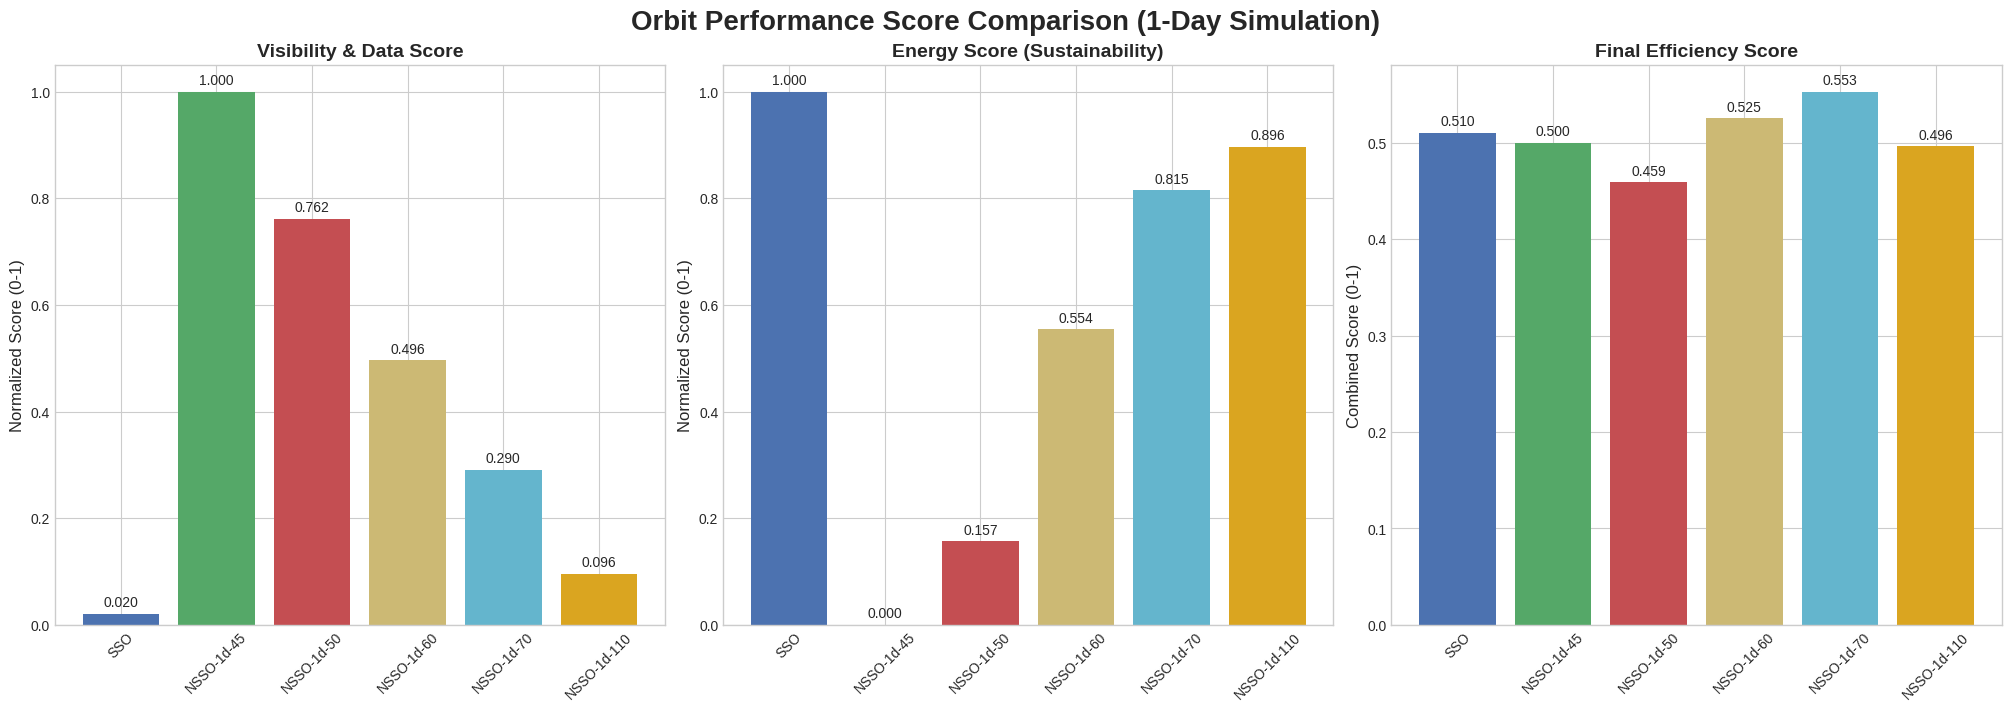

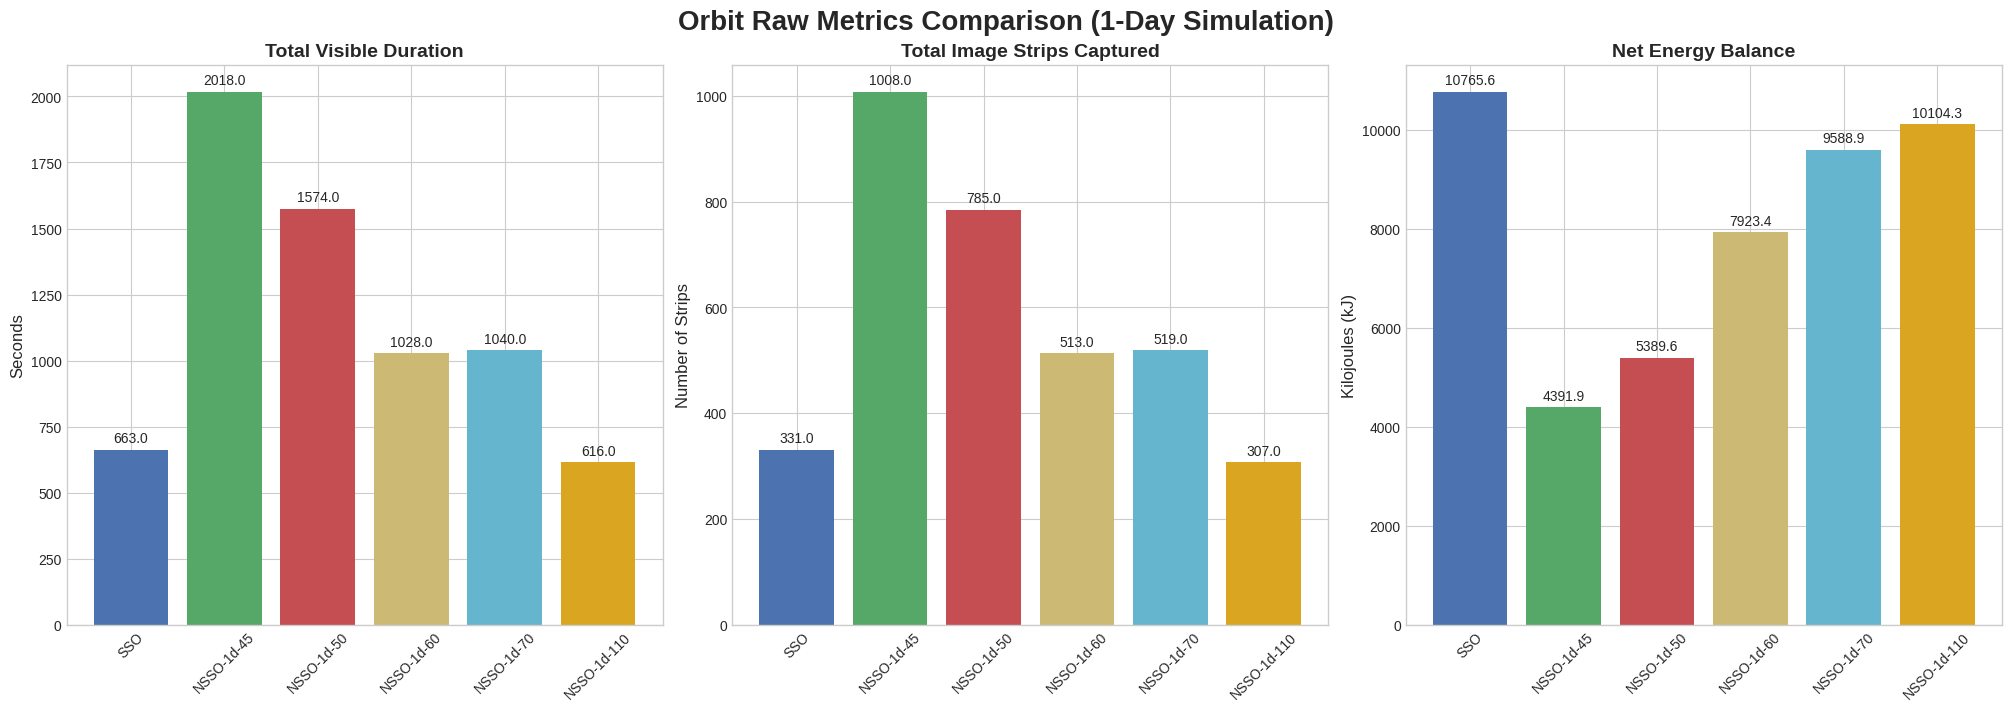

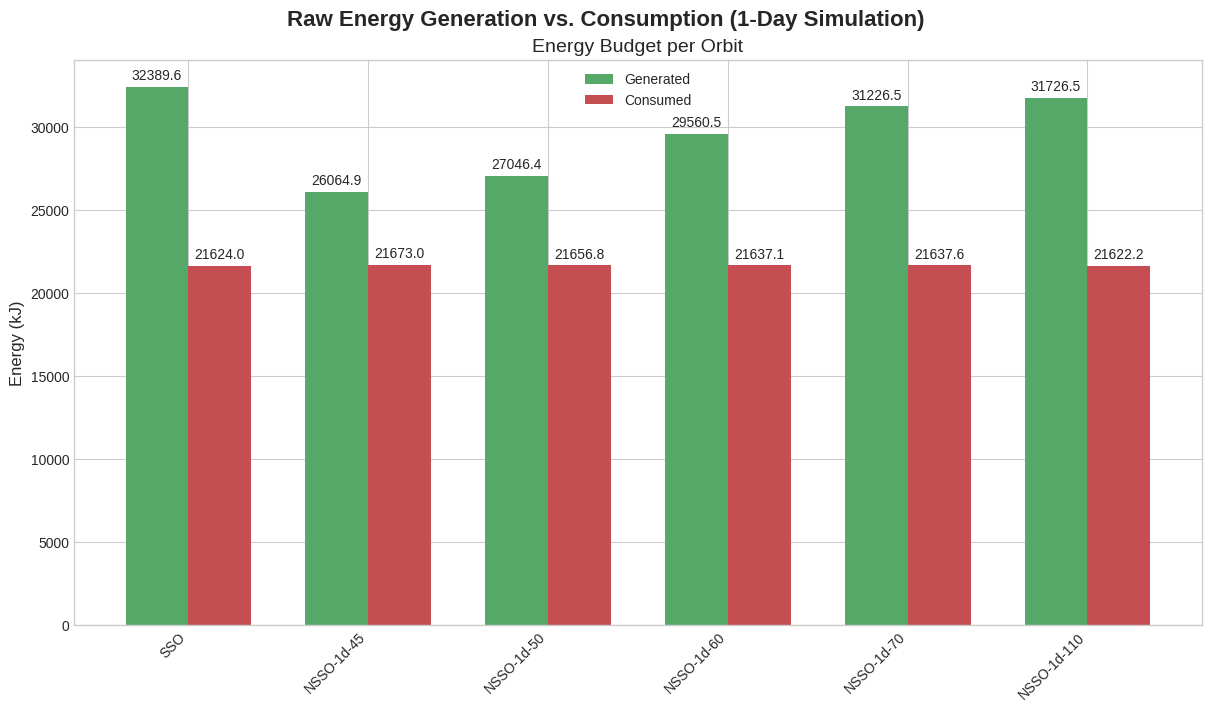

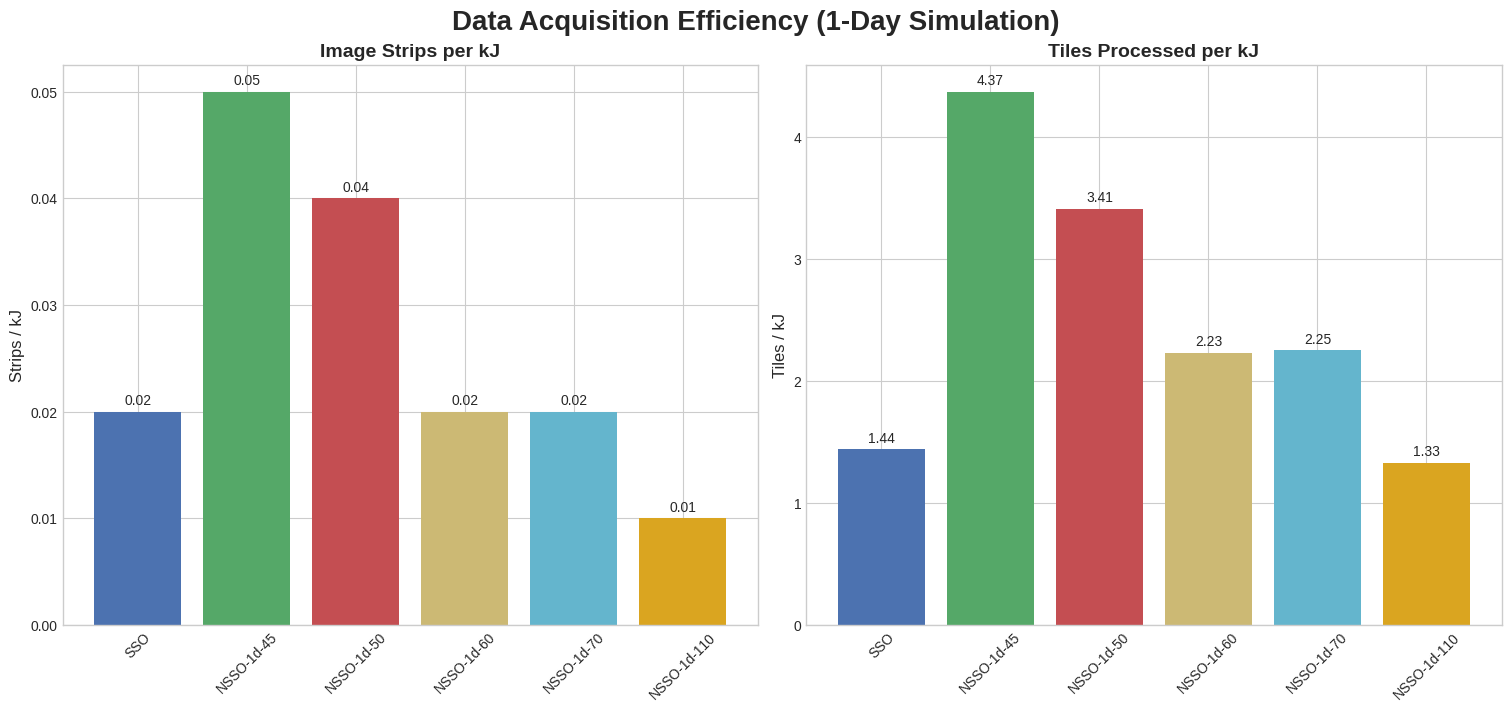


--- Simulation Complete ---


In [ ]:
# File: final_efficiency_score_simulation_1day_corrected.py
# Description: This script performs a 1-day analysis, calculating a composite
#              "Efficiency Score" that combines both visibility and energy metrics
#              using RELATIVE scoring. It also generates comparative bar charts.

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta, time, timezone
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

print("🚀 Initializing Final 1-Day Efficiency Score Simulation (Corrected Model)...")

# ==============================================================================
# 1. CORE SIMULATION & SATELLITE PARAMETERS
# ==============================================================================

# --- Physical and Orbital Constants (SI units) ---
MU = 3.986004418e14      # Earth's gravitational parameter, m^3/s^2
R_EARTH = 6371e3          # Earth's mean radius, m
J2 = 1.08263e-3           # Earth’s J2 perturbation coefficient
OMEGA_EARTH = 7.2921159e-5  # Earth rotation rate, rad/s
SOLAR_CONSTANT = 1361     # Solar irradiance at 1 AU, W/m^2

# --- Simulation Time Parameters ---
EPOCH = datetime(2025, 3, 20, 0, 0, 0)
SIM_DURATION_SEC = 1 * 24 * 3600  # 1 day
ENERGY_SIM_TIME_STEP_SEC = 10
PASS_FINDING_TIME_STEP_SEC = 1

# --- Ground Target (Incheon Airport) & Daylight Definition ---
TARGET_LAT = np.radians(37.4602)
TARGET_LON = np.radians(126.4407)
MIN_ELEVATION = np.radians(20)

KST_OFFSET = timedelta(hours=9)
# Reduced to a single day for the simulation
DAILY_SUN_TIMES_KST = {
    '2025-03-20': (time(6, 36), time(18, 43)),
    '2025-03-21': (time(6, 34), time(18, 44)),
}

# ==============================================================================
# 2. ENERGY CONSUMPTION MODEL (Dynamic Payload Consumption)
# ==============================================================================
print("  - Defining dynamic energy consumption model...")
P_capture = 300.0; t_capture = 0.1; E_capture = P_capture * t_capture
P_process = 15.0; t_process_per_tile = 0.03; E_process_per_tile = P_process * t_process_per_tile
P_tx = 10.0; t_tx = 0.01; E_tx = P_tx * t_tx
P_standby = 250.0 # Lump standby power

lines_per_strip = 1100
pixels_across_swath = 24000
tile_size_px = 640
overlap_ratio = 0.20

step_size_px = int(tile_size_px * (1 - overlap_ratio))
num_tiles_vertical = int(np.ceil(max(0, lines_per_strip - tile_size_px) / step_size_px)) + 1
num_tiles_horizontal = int(np.ceil(max(0, pixels_across_swath - tile_size_px) / step_size_px)) + 1
num_tiles_per_strip = num_tiles_vertical * num_tiles_horizontal
t_process_total_per_strip = num_tiles_per_strip * t_process_per_tile
E_process_total_per_strip = num_tiles_per_strip * E_process_per_tile

E_ACTIVE_STRIP = E_capture + E_process_total_per_strip + E_tx
T_ACTIVE_STRIP = t_capture + t_process_total_per_strip + t_tx

INTERVAL_BETWEEN_STRIPS = 2.0 # seconds

# ==============================================================================
# 3. ENERGY GENERATION MODEL
# ==============================================================================
print("  - Defining energy generation model...")
SOLAR_PANEL_AREA = 3.8
SOLAR_PANEL_EFFICIENCY = 0.295
PANEL_NORMALS_BODY = {
    'panel_+X': np.array([1, 0, 0]), 'panel_-X': np.array([-1, 0, 0]),
    'panel_+Y': np.array([0, 1, 0]), 'panel_-Y': np.array([0, -1, 0]),
}
SINGLE_PANEL_AREA = SOLAR_PANEL_AREA / 4

# ==============================================================================
# 4. HELPER & ASTRODYNAMICS FUNCTIONS
# ==============================================================================

def get_sun_vector(current_time):
    day_of_year = (current_time - datetime(current_time.year, 1, 1)).total_seconds() / (24 * 3600)
    mean_anomaly_sun = np.radians((357.5291 + 0.98560028 * day_of_year) % 360)
    ecliptic_lon = np.radians((280.4665 + 0.98564736 * day_of_year) % 360 + 1.9148 * np.sin(mean_anomaly_sun))
    obliquity = np.radians(23.4393)
    sun_vec_ecliptic = np.array([np.cos(ecliptic_lon), np.sin(ecliptic_lon), 0])
    rot_matrix = np.array([[1, 0, 0], [0, np.cos(obliquity), -np.sin(obliquity)], [0, np.sin(obliquity), np.cos(obliquity)]])
    return rot_matrix @ sun_vec_ecliptic

def solve_kepler(M, e, tol=1e-8):
    E = M if e < 0.8 else np.pi
    for _ in range(100):
        f = E - e * np.sin(E) - M; f_prime = 1 - e * np.cos(E)
        if abs(f_prime) < 1e-10: break
        E -= f / f_prime
        if abs(f) < tol: break
    return E

def propagate_state_vector(a, e, inc, RAAN, AOP, M0, t):
    n = np.sqrt(MU / a**3); p = a * (1 - e**2)
    Omega_dot = -1.5 * J2 * (R_EARTH**2) * n * np.cos(inc) / (p**2)
    omega_dot = 0.75 * J2 * (R_EARTH**2) * n * (5 * np.cos(inc)**2 - 1) / (p**2)
    M_dot = n + 0.75 * J2 * (R_EARTH**2) * n * (3 * np.cos(inc)**2 - 1) / (p**2)
    RAAN_t = RAAN + Omega_dot * t; AOP_t = AOP + omega_dot * t; M_t = M0 + M_dot * t
    E = solve_kepler(M_t % (2 * np.pi), e)
    TA = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))
    r_mag = a * (1 - e * np.cos(E)); r_pf = np.array([r_mag * np.cos(TA), r_mag * np.sin(TA), 0])
    cos_RAAN, sin_RAAN = np.cos(RAAN_t), np.sin(RAAN_t)
    cos_inc, sin_inc = np.cos(inc), np.sin(inc)
    cos_AOP, sin_AOP = np.cos(AOP_t), np.sin(AOP_t)
    R1 = np.array([[cos_RAAN, -sin_RAAN, 0], [sin_RAAN, cos_RAAN, 0], [0, 0, 1]])
    R2 = np.array([[1, 0, 0], [0, cos_inc, -sin_inc], [0, sin_inc, cos_inc]])
    R3 = np.array([[cos_AOP, -sin_AOP, 0], [sin_AOP, cos_AOP, 0], [0, 0, 1]])
    return R1 @ R2 @ R3 @ r_pf

def find_passes(orb_params, duration_sec, time_step):
    pass_list = []; current_pass = []
    a = R_EARTH + orb_params["altitude_km"] * 1000
    inc_rad = np.radians(orb_params["inclination_deg"]); RAAN_rad = np.radians(orb_params["RAAN_deg"])
    AOP_rad = np.radians(orb_params["AOP_deg"]); M0_rad = np.radians(orb_params["M0_deg"]); e = orb_params["e"]
    r_tgt_ecef = np.array([R_EARTH*np.cos(TARGET_LAT)*np.cos(TARGET_LON), R_EARTH*np.cos(TARGET_LAT)*np.sin(TARGET_LON), R_EARTH*np.sin(TARGET_LAT)])

    for t_sec in range(0, duration_sec, time_step):
        r_eci = propagate_state_vector(a, e, inc_rad, RAAN_rad, AOP_rad, M0_rad, t_sec)
        gst = OMEGA_EARTH * t_sec
        x_ecef_sat = r_eci[0] * np.cos(gst) + r_eci[1] * np.sin(gst)
        y_ecef_sat = -r_eci[0] * np.sin(gst) + r_eci[1] * np.cos(gst)
        r_sat_ecef = np.array([x_ecef_sat, y_ecef_sat, r_eci[2]])
        r_los_ecef = r_sat_ecef - r_tgt_ecef
        elevation = np.arcsin(np.clip(np.dot(r_los_ecef, r_tgt_ecef) / (np.linalg.norm(r_los_ecef) * np.linalg.norm(r_tgt_ecef)), -1.0, 1.0))
        is_currently_visible = elevation >= MIN_ELEVATION
        current_time = EPOCH + timedelta(seconds=t_sec)
        if is_currently_visible and not current_pass: current_pass.append(current_time)
        elif not is_currently_visible and current_pass:
            current_pass.append(current_time); pass_list.append(tuple(current_pass)); current_pass = []
    if current_pass: pass_list.append((current_pass[0], EPOCH + timedelta(seconds=duration_sec)))
    return pass_list

def get_daytime_passes(all_passes):
    daytime_passes = []
    kst_tz = timezone(KST_OFFSET)
    for p_start_naive, p_end_naive in all_passes:
        p_start_utc = p_start_naive.replace(tzinfo=timezone.utc)
        p_end_utc = p_end_naive.replace(tzinfo=timezone.utc)
        pass_date_kst = p_start_utc.astimezone(kst_tz)
        pass_date_str = pass_date_kst.strftime('%Y-%m-%d')
        if pass_date_str in DAILY_SUN_TIMES_KST:
            sunrise_kst_t, sunset_kst_t = DAILY_SUN_TIMES_KST[pass_date_str]
            sunrise_dt_kst = datetime.combine(pass_date_kst.date(), sunrise_kst_t, tzinfo=kst_tz)
            sunset_dt_kst = datetime.combine(pass_date_kst.date(), sunset_kst_t, tzinfo=kst_tz)
            if p_start_utc < sunset_dt_kst and p_end_utc > sunrise_dt_kst:
                daytime_passes.append((p_start_naive, p_end_naive))
    return daytime_passes

# ==============================================================================
# 5. MAIN SIMULATION EXECUTION
# ==============================================================================

if __name__ == "__main__":
    orbits_to_simulate = [
        {"label": "SSO", "altitude_km": 685, "inclination_deg": 98.116, "RAAN_deg": 300, "AOP_deg": 0, "M0_deg": 0, "e": 0.0001},
        {"label": "NSSO-1d-45", "altitude_km": 685, "inclination_deg": 45, "RAAN_deg": 60, "AOP_deg": 0, "M0_deg": 300, "e": 0.001},
        {"label": "NSSO-1d-50", "altitude_km": 685, "inclination_deg": 50, "RAAN_deg": 60, "AOP_deg": 0, "M0_deg": 300, "e": 0.001},
        {"label": "NSSO-1d-60", "altitude_km": 685, "inclination_deg": 60, "RAAN_deg": 120, "AOP_deg": 0, "M0_deg": 180, "e": 0.001},
        {"label": "NSSO-1d-70", "altitude_km": 685, "inclination_deg": 70, "RAAN_deg": 120, "AOP_deg": 0, "M0_deg": 180, "e": 0.001},
        {"label": "NSSO-1d-110", "altitude_km": 685, "inclination_deg": 110, "RAAN_deg": 240, "AOP_deg": 0, "M0_deg": 60, "e": 0.001},
    ]
    results = []
    for orb in orbits_to_simulate:
        print(f"\nProcessing orbit: {orb['label']}...")
        geometric_passes = find_passes(orb, SIM_DURATION_SEC, PASS_FINDING_TIME_STEP_SEC)
        daytime_passes = get_daytime_passes(geometric_passes)
        total_visible_duration = sum([(p[1] - p[0]).total_seconds() for p in daytime_passes])
        max_pass_duration = max([ (p[1] - p[0]).total_seconds() for p in daytime_passes], default=0)
        total_strips_captured = 0
        total_active_energy_J = 0
        total_active_duration_s = 0
        for p_start, p_end in daytime_passes:
            pass_duration_s = (p_end - p_start).total_seconds()
            num_strips_in_pass = pass_duration_s // INTERVAL_BETWEEN_STRIPS
            total_strips_captured += num_strips_in_pass
            total_active_energy_J += num_strips_in_pass * E_ACTIVE_STRIP
            total_active_duration_s += num_strips_in_pass * T_ACTIVE_STRIP
        total_standby_duration_s = SIM_DURATION_SEC
        total_standby_energy_J = total_standby_duration_s * P_standby
        total_energy_consumed_J = total_active_energy_J + total_standby_energy_J
        total_energy_generated_J = 0.0
        a = R_EARTH + orb["altitude_km"] * 1000; inc_rad = np.radians(orb["inclination_deg"]); RAAN_rad = np.radians(orb["RAAN_deg"])
        AOP_rad = np.radians(orb["AOP_deg"]); M0_rad = np.radians(orb["M0_deg"]); e = orb["e"]
        for t_sec in range(0, SIM_DURATION_SEC, ENERGY_SIM_TIME_STEP_SEC):
            current_time = EPOCH + timedelta(seconds=t_sec)
            r_sat_eci = propagate_state_vector(a, e, inc_rad, RAAN_rad, AOP_rad, M0_rad, t_sec)
            sun_vec_eci = get_sun_vector(current_time)
            is_in_sunlight = np.dot(r_sat_eci, sun_vec_eci) > 0 or np.linalg.norm(r_sat_eci)**2 - np.dot(r_sat_eci, sun_vec_eci)**2 > R_EARTH**2
            if is_in_sunlight:
                z_body = -r_sat_eci / np.linalg.norm(r_sat_eci)
                r_sat_next = propagate_state_vector(a, e, inc_rad, RAAN_rad, AOP_rad, M0_rad, t_sec + 1)
                v_sat_eci = r_sat_next - r_sat_eci
                y_body = -np.cross(r_sat_eci, v_sat_eci); y_body /= np.linalg.norm(y_body)
                x_body = np.cross(y_body, z_body)
                sun_vec_body = np.array([np.dot(x_body, sun_vec_eci), np.dot(y_body, sun_vec_eci), np.dot(z_body, sun_vec_eci)])
                power_generated_W = sum(SOLAR_CONSTANT * SINGLE_PANEL_AREA * SOLAR_PANEL_EFFICIENCY * max(0, np.dot(norm, sun_vec_body)) for norm in PANEL_NORMALS_BODY.values())
                total_energy_generated_J += power_generated_W * ENERGY_SIM_TIME_STEP_SEC
        total_energy_consumed_kJ = total_energy_consumed_J / 1000
        strips_per_kJ = total_strips_captured / total_energy_consumed_kJ if total_energy_consumed_kJ > 0 else 0
        tiles_processed_per_kJ = (total_strips_captured * num_tiles_per_strip) / total_energy_consumed_kJ if total_energy_consumed_kJ > 0 else 0
        results.append({"Orbit": orb['label'], "num_daytime_passes": len(daytime_passes), "total_visible_duration": int(total_visible_duration), "max_pass_duration": int(max_pass_duration), "total_strips_captured": int(total_strips_captured), "total_energy_consumed_kJ": round(total_energy_consumed_kJ, 2), "total_energy_generated_kJ": round(total_energy_generated_J / 1000, 2), "net_energy_balance_kJ": round((total_energy_generated_J - total_energy_consumed_J) / 1000, 2), "strips_per_kJ": round(strips_per_kJ, 2), "tiles_processed_per_kJ": round(tiles_processed_per_kJ, 2)})

    # ==========================================================================
    # 6. COMPOSITE SCORE CALCULATION AND FINAL RANKING (RELATIVE SCORING)
    # ==========================================================================
    print("\n" + "="*80 + "\n--- Final Efficiency Score Analysis (1-Day Simulation) ---\n" + "="*80)
    df_results = pd.DataFrame(results)
    metrics_to_normalize = ['num_daytime_passes', 'total_visible_duration', 'max_pass_duration', 'total_strips_captured', 'net_energy_balance_kJ']
    if df_results[metrics_to_normalize].sum().sum() == 0:
        print("⚠️ Warning: All scoring metrics are zero. Cannot calculate a meaningful score.")
        df_results['visibility_score'], df_results['energy_score'], df_results['efficiency_score'] = 0, 0, 0
    else:
        scaler = MinMaxScaler()
        norm_cols = [f"{col}_norm" for col in metrics_to_normalize]
        df_results[norm_cols] = scaler.fit_transform(df_results[metrics_to_normalize])
        vis_weights = {'max_pass': 0.3, 'total_vis': 0.3, 'num_passes': 0.1, 'total_strips': 0.3}
        final_weights = {'visibility': 0.5, 'energy': 0.5}
        df_results['visibility_score'] = (df_results['max_pass_duration_norm'] * vis_weights['max_pass'] + df_results['total_visible_duration_norm'] * vis_weights['total_vis'] + df_results['num_daytime_passes_norm'] * vis_weights['num_passes'] + df_results['total_strips_captured_norm'] * vis_weights['total_strips'])
        df_results['energy_score'] = df_results['net_energy_balance_kJ_norm']
        df_results['efficiency_score'] = (df_results['visibility_score'] * final_weights['visibility'] + df_results['energy_score'] * final_weights['energy'])
    df_final = df_results.sort_values(by='efficiency_score', ascending=False).reset_index(drop=True)
    print("Final Ranked Orbits by Efficiency Score:")
    print(df_final[['Orbit', 'total_strips_captured', 'total_visible_duration', 'net_energy_balance_kJ', 'strips_per_kJ', 'visibility_score', 'energy_score', 'efficiency_score']].to_string())
    save_dir = './'
    try:
        if not os.path.exists(save_dir): os.makedirs(save_dir)
        save_path = os.path.join(save_dir, "Final_Efficiency_Ranking_1day_Relative.csv")
        df_final.to_csv(save_path, index=False)
        print(f"\n✅ Final ranked results saved to: {save_path}")
    except Exception as e:
        print(f"\n❌ Error saving file: {e}")

    # ==========================================================================
    # 7. COMPARATIVE ANALYSIS PLOTS
    # ==========================================================================
    print("\n📊 Generating Key Metrics Comparison Plots...")
    df_plot = df_results.set_index('Orbit')
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = ['#4c72b0', '#55a868', '#c44e52', '#ccb974', '#64b5cd', '#DAA520']

    # --- PLOT 1: SCORES ---
    metrics_to_plot_scores = {'visibility_score': ('Visibility & Data Score', 'Normalized Score (0-1)'), 'energy_score': ('Energy Score (Sustainability)', 'Normalized Score (0-1)'), 'efficiency_score': ('Final Efficiency Score', 'Combined Score (0-1)')}
    fig1, axes1 = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
    fig1.suptitle('Orbit Performance Score Comparison (1-Day Simulation)', fontsize=20, weight='bold')
    for i, (metric, (title, ylabel)) in enumerate(metrics_to_plot_scores.items()):
        ax = axes1[i]
        bars = ax.bar(df_plot.index, df_plot[metric], color=colors)
        ax.set_title(title, fontsize=14, weight='bold')
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='x', labelsize=10, labelrotation=45)
        ax.bar_label(bars, fmt='%.3f', padding=3)
    try:
        plot_save_path_scores = os.path.join(save_dir, "Score_Metrics_Comparison_1day.png")
        plt.savefig(plot_save_path_scores, dpi=300)
        print(f"✅ Score comparison plot successfully saved to: {plot_save_path_scores}")
    except Exception as e:
        print(f"❌ Error saving score plot: {e}")

    # --- PLOT 2: RAW METRICS ---
    metrics_to_plot_raw = {'total_visible_duration': ('Total Visible Duration', 'Seconds'), 'total_strips_captured': ('Total Image Strips Captured', 'Number of Strips'), 'net_energy_balance_kJ': ('Net Energy Balance', 'Kilojoules (kJ)')}
    fig2, axes2 = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
    fig2.suptitle('Orbit Raw Metrics Comparison (1-Day Simulation)', fontsize=20, weight='bold')
    for i, (metric, (title, ylabel)) in enumerate(metrics_to_plot_raw.items()):
        ax = axes2[i]
        bars = ax.bar(df_plot.index, df_plot[metric], color=colors)
        ax.set_title(title, fontsize=14, weight='bold')
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='x', labelsize=10, labelrotation=45)
        ax.bar_label(bars, fmt='%.1f', padding=3)
    try:
        plot_save_path_raw = os.path.join(save_dir, "Raw_Metrics_Comparison_1day.png")
        plt.savefig(plot_save_path_raw, dpi=300)
        print(f"✅ Raw metrics comparison plot successfully saved to: {plot_save_path_raw}")
    except Exception as e:
        print(f"❌ Error saving raw metrics plot: {e}")

    # --- PLOT 3: RAW ENERGY GENERATION VS CONSUMPTION ---
    fig3, ax3 = plt.subplots(figsize=(12, 7), constrained_layout=True)
    fig3.suptitle('Raw Energy Generation vs. Consumption (1-Day Simulation)', fontsize=16, weight='bold')
    index = np.arange(len(df_plot.index))
    bar_width = 0.35
    bars_gen = ax3.bar(index - bar_width/2, df_plot['total_energy_generated_kJ'], bar_width, label='Generated', color='#55a868')
    bars_con = ax3.bar(index + bar_width/2, df_plot['total_energy_consumed_kJ'], bar_width, label='Consumed', color='#c44e52')
    ax3.set_ylabel('Energy (kJ)', fontsize=12)
    ax3.set_title('Energy Budget per Orbit', fontsize=14)
    ax3.set_xticks(index)
    ax3.set_xticklabels(df_plot.index, rotation=45, ha="right", fontsize=10)
    ax3.legend()
    ax3.bar_label(bars_gen, fmt='%.1f', padding=3)
    ax3.bar_label(bars_con, fmt='%.1f', padding=3)
    try:
        plot_save_path_energy = os.path.join(save_dir, "Energy_Budget_Comparison_1day.png")
        plt.savefig(plot_save_path_energy, dpi=300)
        print(f"✅ Energy budget comparison plot successfully saved to: {plot_save_path_energy}")
    except Exception as e:
        print(f"❌ Error saving energy budget plot: {e}")

    # --- PLOT 4: EFFICIENCY METRICS ---
    metrics_to_plot_efficiency = {'strips_per_kJ': ('Image Strips per kJ', 'Strips / kJ'), 'tiles_processed_per_kJ': ('Tiles Processed per kJ', 'Tiles / kJ')}
    fig4, axes4 = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)
    fig4.suptitle('Data Acquisition Efficiency (1-Day Simulation)', fontsize=20, weight='bold')
    for i, (metric, (title, ylabel)) in enumerate(metrics_to_plot_efficiency.items()):
        ax = axes4[i]
        bars = ax.bar(df_plot.index, df_plot[metric], color=colors)
        ax.set_title(title, fontsize=14, weight='bold')
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='x', labelsize=10, labelrotation=45)
        ax.bar_label(bars, fmt='%.2f', padding=3)
    try:
        plot_save_path_eff = os.path.join(save_dir, "Efficiency_Metrics_Comparison_1day.png")
        plt.savefig(plot_save_path_eff, dpi=300)
        print(f"✅ Efficiency metrics plot successfully saved to: {plot_save_path_eff}")
    except Exception as e:
        print(f"❌ Error saving efficiency plot: {e}")

    plt.show()

    print("\n--- Simulation Complete ---")


🚀 Initializing Final 7-Day Efficiency Score Simulation...
  - Defining dynamic energy consumption model...
  - Defining energy generation model...

Processing orbit: SSO...

Processing orbit: NSSO-7d-45...

Processing orbit: NSSO-7d-50...

Processing orbit: NSSO-7d-60...

Processing orbit: NSSO-7d-70...

Processing orbit: NSSO-7d-110...

--- Final Efficiency Score Analysis (7-Day Simulation) ---
Final Ranked Orbits by Efficiency Score:
         Orbit  total_strips_captured  total_visible_duration  net_energy_balance_kJ  strips_per_kJ  visibility_score  energy_score  efficiency_score
0   NSSO-7d-70                   2695                    5390               97321.99           0.02          0.315542      1.000000          0.657771
1   NSSO-7d-60                   3475                    6950               74377.14           0.02          0.478630      0.557436          0.518033
2   NSSO-7d-45                   6455                   12910               45476.71           0.04          1

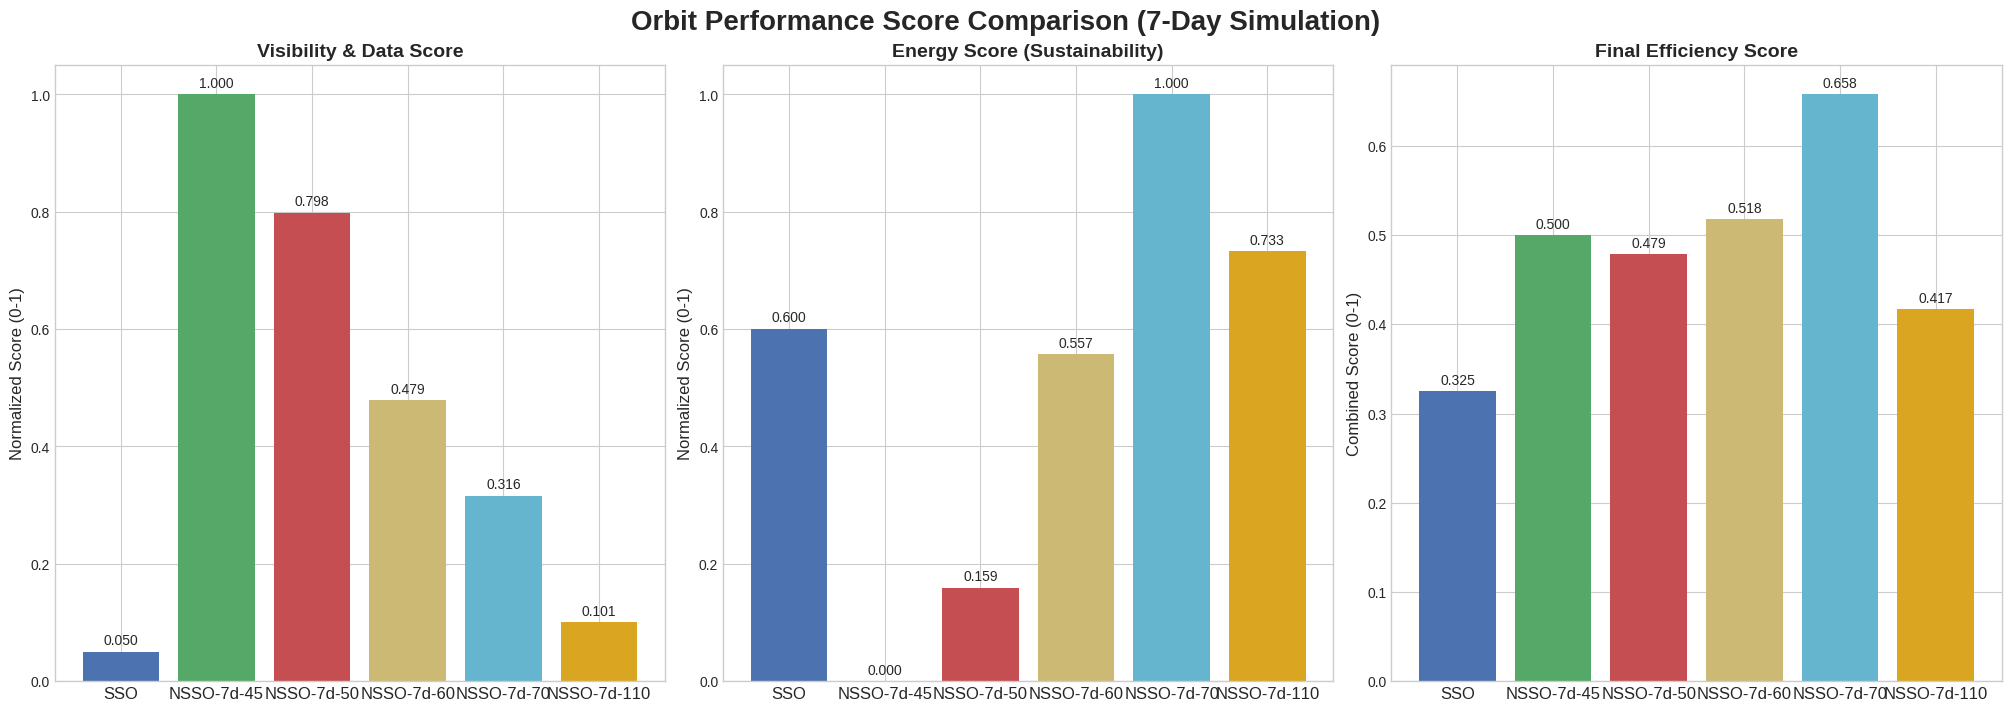

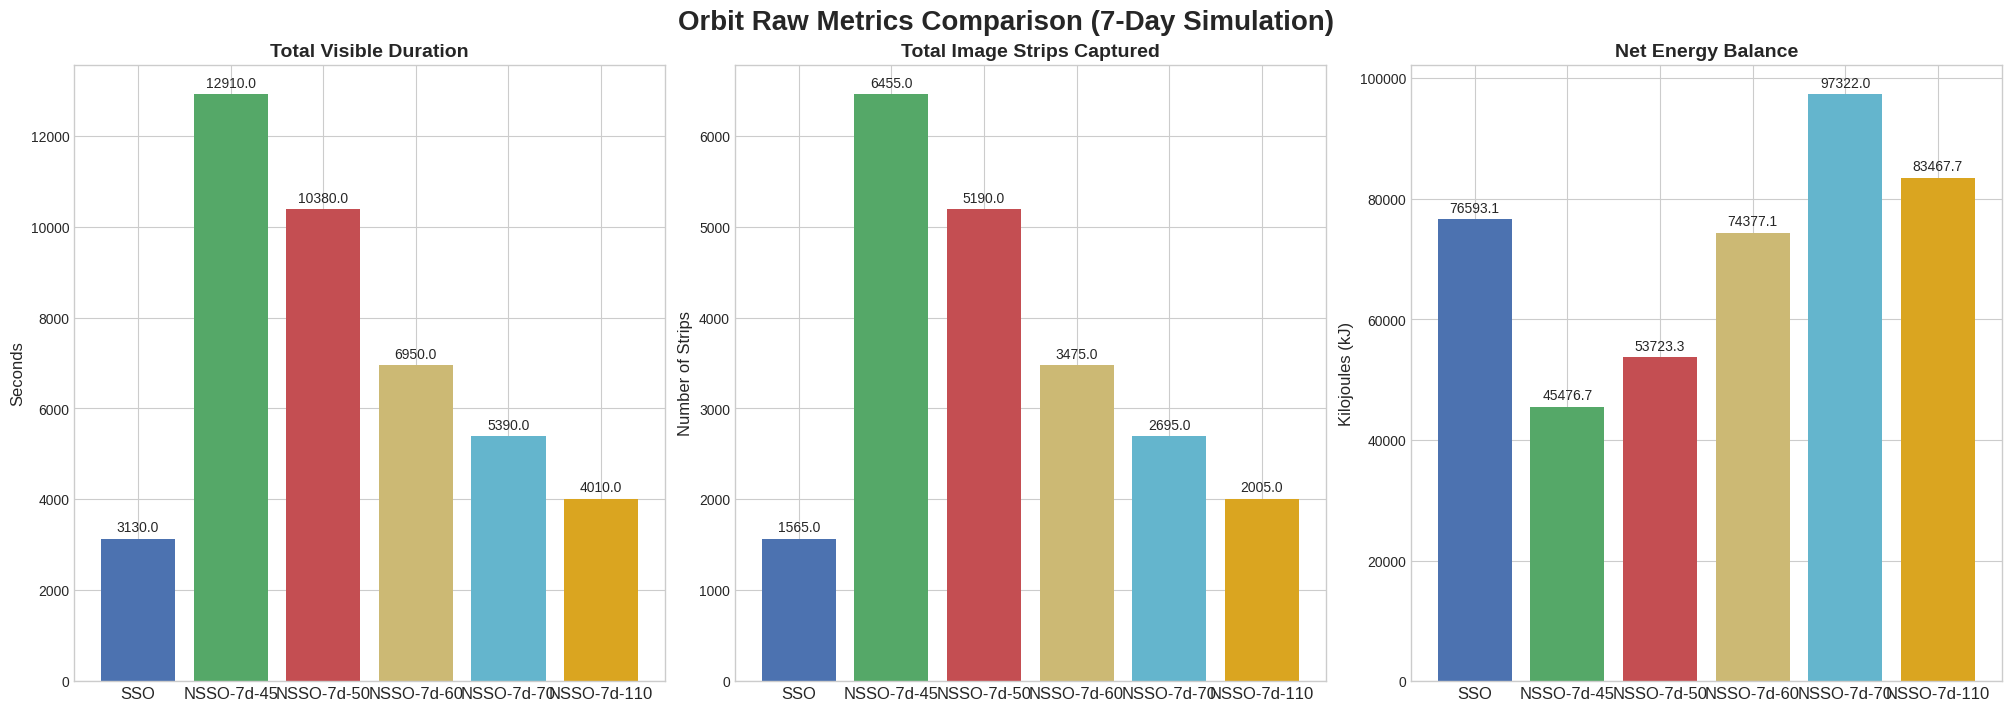

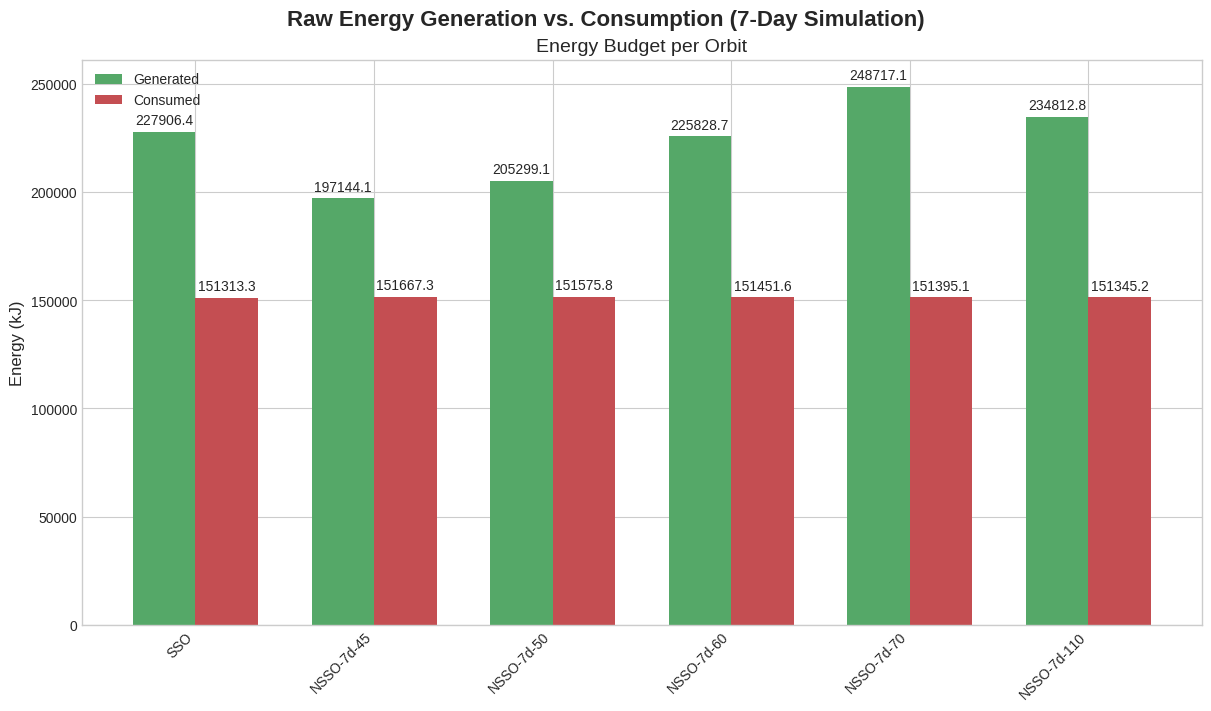

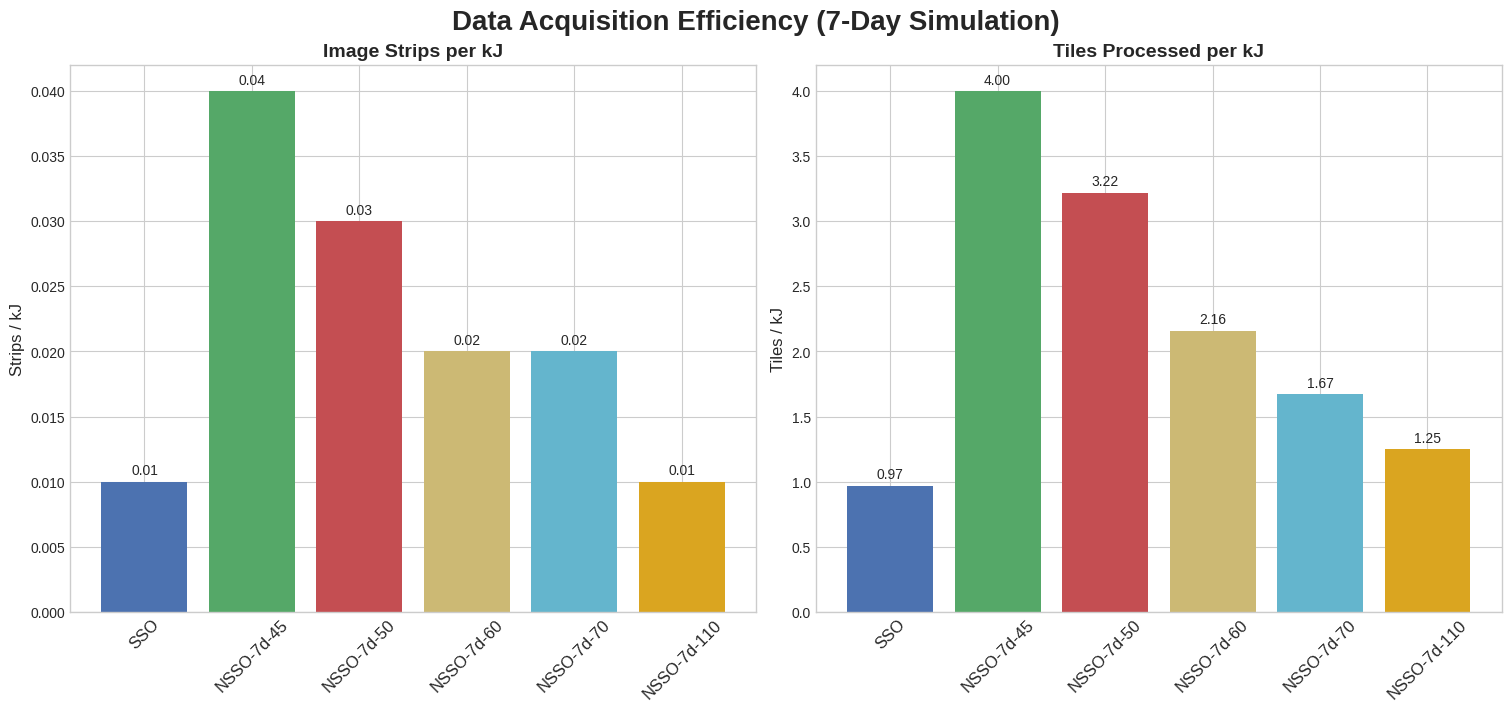


--- Simulation Complete ---


In [ ]:
# File: final_efficiency_score_simulation_7day.py
# Description: This script performs a 7-day analysis, calculating a composite
#              "Efficiency Score" that combines both visibility and energy metrics
#              using RELATIVE scoring. It also generates comparative bar charts.

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta, time, timezone
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

print("🚀 Initializing Final 7-Day Efficiency Score Simulation...")

# ==============================================================================
# 1. CORE SIMULATION & SATELLITE PARAMETERS
# ==============================================================================

# --- Physical and Orbital Constants (SI units) ---
MU = 3.986004418e14      # Earth's gravitational parameter, m^3/s^2
R_EARTH = 6371e3          # Earth's mean radius, m
J2 = 1.08263e-3           # Earth’s J2 perturbation coefficient
OMEGA_EARTH = 7.2921159e-5  # Earth rotation rate, rad/s
SOLAR_CONSTANT = 1361     # Solar irradiance at 1 AU, W/m^2

# --- Simulation Time Parameters ---
EPOCH = datetime(2025, 3, 20, 0, 0, 0)
SIM_DURATION_SEC = 7 * 24 * 3600
ENERGY_SIM_TIME_STEP_SEC = 10
PASS_FINDING_TIME_STEP_SEC = 10

# --- Ground Target (Incheon Airport) & Daylight Definition ---
TARGET_LAT = np.radians(37.4602)
TARGET_LON = np.radians(126.4407)
MIN_ELEVATION = np.radians(20)

KST_OFFSET = timedelta(hours=9)
DAILY_SUN_TIMES_KST = {
    '2025-03-20': (time(6, 36), time(18, 43)),
    '2025-03-21': (time(6, 34), time(18, 44)),
    '2025-03-22': (time(6, 32), time(18, 45)),
    '2025-03-23': (time(6, 31), time(18, 46)),
    '2025-03-24': (time(6, 29), time(18, 47)),
    '2025-03-25': (time(6, 28), time(18, 48)),
    '2025-03-26': (time(6, 26), time(18, 49)),
    '2025-03-27': (time(6, 25), time(18, 50)),
}

# ==============================================================================
# 2. ENERGY CONSUMPTION MODEL (Dynamic Payload Consumption)
# ==============================================================================
print("  - Defining dynamic energy consumption model...")
P_capture = 300.0; t_capture = 0.1; E_capture = P_capture * t_capture
P_process = 15.0; t_process_per_tile = 0.03; E_process_per_tile = P_process * t_process_per_tile
P_tx = 10.0; t_tx = 0.01; E_tx = P_tx * t_tx
P_standby = 250.0 # Lump standby power

lines_per_strip = 1100
pixels_across_swath = 24000
tile_size_px = 640
overlap_ratio = 0.20

step_size_px = int(tile_size_px * (1 - overlap_ratio))
num_tiles_vertical = int(np.ceil(max(0, lines_per_strip - tile_size_px) / step_size_px)) + 1
num_tiles_horizontal = int(np.ceil(max(0, pixels_across_swath - tile_size_px) / step_size_px)) + 1
num_tiles_per_strip = num_tiles_vertical * num_tiles_horizontal
t_process_total_per_strip = num_tiles_per_strip * t_process_per_tile
E_process_total_per_strip = num_tiles_per_strip * E_process_per_tile

E_ACTIVE_STRIP = E_capture + E_process_total_per_strip + E_tx
T_ACTIVE_STRIP = t_capture + t_process_total_per_strip + t_tx

INTERVAL_BETWEEN_STRIPS = 2.0 # seconds

# ==============================================================================
# 3. ENERGY GENERATION MODEL
# ==============================================================================
print("  - Defining energy generation model...")
SOLAR_PANEL_AREA = 3.8
SOLAR_PANEL_EFFICIENCY = 0.295
PANEL_NORMALS_BODY = {
    'panel_+X': np.array([1, 0, 0]), 'panel_-X': np.array([-1, 0, 0]),
    'panel_+Y': np.array([0, 1, 0]), 'panel_-Y': np.array([0, -1, 0]),
}
SINGLE_PANEL_AREA = SOLAR_PANEL_AREA / 4

# ==============================================================================
# 4. HELPER & ASTRODYNAMICS FUNCTIONS
# ==============================================================================

def get_sun_vector(current_time):
    day_of_year = (current_time - datetime(current_time.year, 1, 1)).total_seconds() / (24 * 3600)
    mean_anomaly_sun = np.radians((357.5291 + 0.98560028 * day_of_year) % 360)
    ecliptic_lon = np.radians((280.4665 + 0.98564736 * day_of_year) % 360 + 1.9148 * np.sin(mean_anomaly_sun))
    obliquity = np.radians(23.4393)
    sun_vec_ecliptic = np.array([np.cos(ecliptic_lon), np.sin(ecliptic_lon), 0])
    rot_matrix = np.array([[1, 0, 0], [0, np.cos(obliquity), -np.sin(obliquity)], [0, np.sin(obliquity), np.cos(obliquity)]])
    return rot_matrix @ sun_vec_ecliptic

def solve_kepler(M, e, tol=1e-8):
    E = M if e < 0.8 else np.pi
    for _ in range(100):
        f = E - e * np.sin(E) - M; f_prime = 1 - e * np.cos(E)
        if abs(f_prime) < 1e-10: break
        E -= f / f_prime
        if abs(f) < tol: break
    return E

def propagate_state_vector(a, e, inc, RAAN, AOP, M0, t):
    n = np.sqrt(MU / a**3); p = a * (1 - e**2)
    Omega_dot = -1.5 * J2 * (R_EARTH**2) * n * np.cos(inc) / (p**2)
    omega_dot = 0.75 * J2 * (R_EARTH**2) * n * (5 * np.cos(inc)**2 - 1) / (p**2)
    M_dot = n + 0.75 * J2 * (R_EARTH**2) * n * (3 * np.cos(inc)**2 - 1) / (p**2)
    RAAN_t = RAAN + Omega_dot * t; AOP_t = AOP + omega_dot * t; M_t = M0 + M_dot * t
    E = solve_kepler(M_t % (2 * np.pi), e)
    TA = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))
    r_mag = a * (1 - e * np.cos(E)); r_pf = np.array([r_mag * np.cos(TA), r_mag * np.sin(TA), 0])
    cos_RAAN, sin_RAAN = np.cos(RAAN_t), np.sin(RAAN_t)
    cos_inc, sin_inc = np.cos(inc), np.sin(inc)
    cos_AOP, sin_AOP = np.cos(AOP_t), np.sin(AOP_t)
    R1 = np.array([[cos_RAAN, -sin_RAAN, 0], [sin_RAAN, cos_RAAN, 0], [0, 0, 1]])
    R2 = np.array([[1, 0, 0], [0, cos_inc, -sin_inc], [0, sin_inc, cos_inc]])
    R3 = np.array([[cos_AOP, -sin_AOP, 0], [sin_AOP, cos_AOP, 0], [0, 0, 1]])
    return R1 @ R2 @ R3 @ r_pf

def find_passes(orb_params, duration_sec, time_step):
    pass_list = []; current_pass = []
    a = R_EARTH + orb_params["altitude_km"] * 1000
    inc_rad = np.radians(orb_params["inclination_deg"]); RAAN_rad = np.radians(orb_params["RAAN_deg"])
    AOP_rad = np.radians(orb_params["AOP_deg"]); M0_rad = np.radians(orb_params["M0_deg"]); e = orb_params["e"]
    r_tgt_ecef = np.array([R_EARTH*np.cos(TARGET_LAT)*np.cos(TARGET_LON), R_EARTH*np.cos(TARGET_LAT)*np.sin(TARGET_LON), R_EARTH*np.sin(TARGET_LAT)])

    for t_sec in range(0, duration_sec, time_step):
        r_eci = propagate_state_vector(a, e, inc_rad, RAAN_rad, AOP_rad, M0_rad, t_sec)
        gst = OMEGA_EARTH * t_sec
        x_ecef_sat = r_eci[0] * np.cos(gst) + r_eci[1] * np.sin(gst)
        y_ecef_sat = -r_eci[0] * np.sin(gst) + r_eci[1] * np.cos(gst)
        r_sat_ecef = np.array([x_ecef_sat, y_ecef_sat, r_eci[2]])
        r_los_ecef = r_sat_ecef - r_tgt_ecef
        elevation = np.arcsin(np.clip(np.dot(r_los_ecef, r_tgt_ecef) / (np.linalg.norm(r_los_ecef) * np.linalg.norm(r_tgt_ecef)), -1.0, 1.0))
        is_currently_visible = elevation >= MIN_ELEVATION
        current_time = EPOCH + timedelta(seconds=t_sec)
        if is_currently_visible and not current_pass: current_pass.append(current_time)
        elif not is_currently_visible and current_pass:
            current_pass.append(current_time); pass_list.append(tuple(current_pass)); current_pass = []
    if current_pass: pass_list.append((current_pass[0], EPOCH + timedelta(seconds=duration_sec)))
    return pass_list

def get_daytime_passes(all_passes):
    daytime_passes = []
    kst_tz = timezone(KST_OFFSET)
    for p_start_naive, p_end_naive in all_passes:
        p_start_utc = p_start_naive.replace(tzinfo=timezone.utc)
        p_end_utc = p_end_naive.replace(tzinfo=timezone.utc)
        pass_date_kst = p_start_utc.astimezone(kst_tz)
        pass_date_str = pass_date_kst.strftime('%Y-%m-%d')
        if pass_date_str in DAILY_SUN_TIMES_KST:
            sunrise_kst_t, sunset_kst_t = DAILY_SUN_TIMES_KST[pass_date_str]
            sunrise_dt_kst = datetime.combine(pass_date_kst.date(), sunrise_kst_t, tzinfo=kst_tz)
            sunset_dt_kst = datetime.combine(pass_date_kst.date(), sunset_kst_t, tzinfo=kst_tz)
            if p_start_utc < sunset_dt_kst and p_end_utc > sunrise_dt_kst:
                daytime_passes.append((p_start_naive, p_end_naive))
    return daytime_passes

# ==============================================================================
# 5. MAIN SIMULATION EXECUTION
# ==============================================================================

if __name__ == "__main__":
    orbits_to_simulate = [
        # Original Candidates
        {"label": "SSO", "altitude_km": 685, "inclination_deg": 98.12, "RAAN_deg": 300, "AOP_deg": 0, "M0_deg": 120, "e": 0.0001},
        {"label": "NSSO-7d-45", "altitude_km": 685, "inclination_deg": 45, "RAAN_deg": 120, "AOP_deg": 0, "M0_deg": 240, "e": 0.001},
        {"label": "NSSO-7d-50", "altitude_km": 685, "inclination_deg": 50, "RAAN_deg": 120, "AOP_deg": 0, "M0_deg": 0, "e": 0.001},
        {"label": "NSSO-7d-60", "altitude_km": 685, "inclination_deg": 60, "RAAN_deg": 120, "AOP_deg": 0, "M0_deg": 240, "e": 0.001},
        {"label": "NSSO-7d-70", "altitude_km": 685, "inclination_deg": 70, "RAAN_deg": 120, "AOP_deg": 0, "M0_deg": 240, "e": 0.001},
        {"label": "NSSO-7d-110", "altitude_km": 685, "inclination_deg": 110, "RAAN_deg": 240, "AOP_deg": 0, "M0_deg": 0, "e": 0.001},
    ]
    results = []
    for orb in orbits_to_simulate:
        print(f"\nProcessing orbit: {orb['label']}...")
        geometric_passes = find_passes(orb, SIM_DURATION_SEC, PASS_FINDING_TIME_STEP_SEC)
        daytime_passes = get_daytime_passes(geometric_passes)
        total_visible_duration = sum([(p[1] - p[0]).total_seconds() for p in daytime_passes])
        max_pass_duration = max([ (p[1] - p[0]).total_seconds() for p in daytime_passes], default=0)
        total_strips_captured = 0
        total_active_energy_J = 0
        total_active_duration_s = 0
        for p_start, p_end in daytime_passes:
            pass_duration_s = (p_end - p_start).total_seconds()
            num_strips_in_pass = pass_duration_s // INTERVAL_BETWEEN_STRIPS
            total_strips_captured += num_strips_in_pass
            total_active_energy_J += num_strips_in_pass * E_ACTIVE_STRIP
            total_active_duration_s += num_strips_in_pass * T_ACTIVE_STRIP
        total_standby_duration_s = SIM_DURATION_SEC
        total_standby_energy_J = total_standby_duration_s * P_standby
        total_energy_consumed_J = total_active_energy_J + total_standby_energy_J
        total_energy_generated_J = 0.0
        a = R_EARTH + orb["altitude_km"] * 1000; inc_rad = np.radians(orb["inclination_deg"]); RAAN_rad = np.radians(orb["RAAN_deg"])
        AOP_rad = np.radians(orb["AOP_deg"]); M0_rad = np.radians(orb["M0_deg"]); e = orb["e"]
        for t_sec in range(0, SIM_DURATION_SEC, ENERGY_SIM_TIME_STEP_SEC):
            current_time = EPOCH + timedelta(seconds=t_sec)
            r_sat_eci = propagate_state_vector(a, e, inc_rad, RAAN_rad, AOP_rad, M0_rad, t_sec)
            sun_vec_eci = get_sun_vector(current_time)
            is_in_sunlight = np.dot(r_sat_eci, sun_vec_eci) > 0 or np.linalg.norm(r_sat_eci)**2 - np.dot(r_sat_eci, sun_vec_eci)**2 > R_EARTH**2
            if is_in_sunlight:
                z_body = -r_sat_eci / np.linalg.norm(r_sat_eci)
                r_sat_next = propagate_state_vector(a, e, inc_rad, RAAN_rad, AOP_rad, M0_rad, t_sec + 1)
                v_sat_eci = r_sat_next - r_sat_eci
                y_body = -np.cross(r_sat_eci, v_sat_eci); y_body /= np.linalg.norm(y_body)
                x_body = np.cross(y_body, z_body)
                sun_vec_body = np.array([np.dot(x_body, sun_vec_eci), np.dot(y_body, sun_vec_eci), np.dot(z_body, sun_vec_eci)])
                power_generated_W = sum(SOLAR_CONSTANT * SINGLE_PANEL_AREA * SOLAR_PANEL_EFFICIENCY * max(0, np.dot(norm, sun_vec_body)) for norm in PANEL_NORMALS_BODY.values())
                total_energy_generated_J += power_generated_W * ENERGY_SIM_TIME_STEP_SEC
        total_energy_consumed_kJ = total_energy_consumed_J / 1000
        strips_per_kJ = total_strips_captured / total_energy_consumed_kJ if total_energy_consumed_kJ > 0 else 0
        tiles_processed_per_kJ = (total_strips_captured * num_tiles_per_strip) / total_energy_consumed_kJ if total_energy_consumed_kJ > 0 else 0
        results.append({"Orbit": orb['label'], "num_daytime_passes": len(daytime_passes), "total_visible_duration": int(total_visible_duration), "max_pass_duration": int(max_pass_duration), "total_strips_captured": int(total_strips_captured), "total_energy_consumed_kJ": round(total_energy_consumed_kJ, 2), "total_energy_generated_kJ": round(total_energy_generated_J / 1000, 2), "net_energy_balance_kJ": round((total_energy_generated_J - total_energy_consumed_J) / 1000, 2), "strips_per_kJ": round(strips_per_kJ, 2), "tiles_processed_per_kJ": round(tiles_processed_per_kJ, 2)})

    # ==========================================================================
    # 6. COMPOSITE SCORE CALCULATION AND FINAL RANKING (RELATIVE SCORING)
    # ==========================================================================
    print("\n" + "="*80 + "\n--- Final Efficiency Score Analysis (7-Day Simulation) ---\n" + "="*80)
    df_results = pd.DataFrame(results)
    metrics_to_normalize = ['num_daytime_passes', 'total_visible_duration', 'max_pass_duration', 'total_strips_captured', 'net_energy_balance_kJ']
    if df_results[metrics_to_normalize].sum().sum() == 0:
        print("⚠️ Warning: All scoring metrics are zero. Cannot calculate a meaningful score.")
        df_results['visibility_score'], df_results['energy_score'], df_results['efficiency_score'] = 0, 0, 0
    else:
        scaler = MinMaxScaler()
        norm_cols = [f"{col}_norm" for col in metrics_to_normalize]
        df_results[norm_cols] = scaler.fit_transform(df_results[metrics_to_normalize])
        vis_weights = {'max_pass': 0.2, 'total_vis': 0.2, 'num_passes': 0.3, 'total_strips': 0.3}
        final_weights = {'visibility': 0.5, 'energy': 0.5}
        df_results['visibility_score'] = (df_results['max_pass_duration_norm'] * vis_weights['max_pass'] + df_results['total_visible_duration_norm'] * vis_weights['total_vis'] + df_results['num_daytime_passes_norm'] * vis_weights['num_passes'] + df_results['total_strips_captured_norm'] * vis_weights['total_strips'])
        df_results['energy_score'] = df_results['net_energy_balance_kJ_norm']
        df_results['efficiency_score'] = (df_results['visibility_score'] * final_weights['visibility'] + df_results['energy_score'] * final_weights['energy'])
    df_final = df_results.sort_values(by='efficiency_score', ascending=False).reset_index(drop=True)
    print("Final Ranked Orbits by Efficiency Score:")
    print(df_final[['Orbit', 'total_strips_captured', 'total_visible_duration', 'net_energy_balance_kJ', 'strips_per_kJ', 'visibility_score', 'energy_score', 'efficiency_score']].to_string())
    save_dir = './'
    try:
        if not os.path.exists(save_dir): os.makedirs(save_dir)
        save_path = os.path.join(save_dir, "Final_Efficiency_Ranking_7day_Relative.csv")
        df_final.to_csv(save_path, index=False)
        print(f"\n✅ Final ranked results saved to: {save_path}")
    except Exception as e:
        print(f"\n❌ Error saving file: {e}")

    # ==========================================================================
    # 7. COMPARATIVE ANALYSIS PLOTS
    # ==========================================================================
    print("\n📊 Generating Key Metrics Comparison Plots...")
    df_plot = df_results.set_index('Orbit')
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = ['#4c72b0', '#55a868', '#c44e52', '#ccb974', '#64b5cd', '#DAA520']

    # --- PLOT 1: SCORES ---
    metrics_to_plot_scores = {'visibility_score': ('Visibility & Data Score', 'Normalized Score (0-1)'), 'energy_score': ('Energy Score (Sustainability)', 'Normalized Score (0-1)'), 'efficiency_score': ('Final Efficiency Score', 'Combined Score (0-1)')}
    fig1, axes1 = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
    fig1.suptitle('Orbit Performance Score Comparison (7-Day Simulation)', fontsize=20, weight='bold')
    for i, (metric, (title, ylabel)) in enumerate(metrics_to_plot_scores.items()):
        ax = axes1[i]
        bars = ax.bar(df_plot.index, df_plot[metric], color=colors)
        ax.set_title(title, fontsize=14, weight='bold')
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='x', labelsize=12, rotation=0)
        ax.bar_label(bars, fmt='%.3f', padding=3)
    try:
        plot_save_path_scores = os.path.join(save_dir, "Score_Metrics_Comparison_7day.png")
        plt.savefig(plot_save_path_scores, dpi=300)
        print(f"✅ Score comparison plot successfully saved to: {plot_save_path_scores}")
    except Exception as e:
        print(f"❌ Error saving score plot: {e}")

    # --- PLOT 2: RAW METRICS ---
    metrics_to_plot_raw = {'total_visible_duration': ('Total Visible Duration', 'Seconds'), 'total_strips_captured': ('Total Image Strips Captured', 'Number of Strips'), 'net_energy_balance_kJ': ('Net Energy Balance', 'Kilojoules (kJ)')}
    fig2, axes2 = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
    fig2.suptitle('Orbit Raw Metrics Comparison (7-Day Simulation)', fontsize=20, weight='bold')
    for i, (metric, (title, ylabel)) in enumerate(metrics_to_plot_raw.items()):
        ax = axes2[i]
        bars = ax.bar(df_plot.index, df_plot[metric], color=colors)
        ax.set_title(title, fontsize=14, weight='bold')
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='x', labelsize=12, rotation=0)
        ax.bar_label(bars, fmt='%.1f', padding=3)
    try:
        plot_save_path_raw = os.path.join(save_dir, "Raw_Metrics_Comparison_7day.png")
        plt.savefig(plot_save_path_raw, dpi=300)
        print(f"✅ Raw metrics comparison plot successfully saved to: {plot_save_path_raw}")
    except Exception as e:
        print(f"❌ Error saving raw metrics plot: {e}")

    # --- PLOT 3: RAW ENERGY GENERATION VS CONSUMPTION ---
    fig3, ax3 = plt.subplots(figsize=(12, 7), constrained_layout=True)
    fig3.suptitle('Raw Energy Generation vs. Consumption (7-Day Simulation)', fontsize=16, weight='bold')
    index = np.arange(len(df_plot.index))
    bar_width = 0.35
    bars_gen = ax3.bar(index - bar_width/2, df_plot['total_energy_generated_kJ'], bar_width, label='Generated', color='#55a868')
    bars_con = ax3.bar(index + bar_width/2, df_plot['total_energy_consumed_kJ'], bar_width, label='Consumed', color='#c44e52')
    ax3.set_ylabel('Energy (kJ)', fontsize=12)
    ax3.set_title('Energy Budget per Orbit', fontsize=14)
    ax3.set_xticks(index)
    ax3.set_xticklabels(df_plot.index, rotation=45, ha="right", fontsize=10)
    ax3.legend()
    ax3.bar_label(bars_gen, fmt='%.1f', padding=3)
    ax3.bar_label(bars_con, fmt='%.1f', padding=3)
    try:
        plot_save_path_energy = os.path.join(save_dir, "Energy_Budget_Comparison_7day.png")
        plt.savefig(plot_save_path_energy, dpi=300)
        print(f"✅ Energy budget comparison plot successfully saved to: {plot_save_path_energy}")
    except Exception as e:
        print(f"❌ Error saving energy budget plot: {e}")

    # --- PLOT 4: EFFICIENCY METRICS ---
    metrics_to_plot_efficiency = {'strips_per_kJ': ('Image Strips per kJ', 'Strips / kJ'), 'tiles_processed_per_kJ': ('Tiles Processed per kJ', 'Tiles / kJ')}
    fig4, axes4 = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)
    fig4.suptitle('Data Acquisition Efficiency (7-Day Simulation)', fontsize=20, weight='bold')
    for i, (metric, (title, ylabel)) in enumerate(metrics_to_plot_efficiency.items()):
        ax = axes4[i]
        bars = ax.bar(df_plot.index, df_plot[metric], color=colors)
        ax.set_title(title, fontsize=14, weight='bold')
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='x', labelsize=12, rotation=45)
        ax.bar_label(bars, fmt='%.2f', padding=3)
    try:
        plot_save_path_eff = os.path.join(save_dir, "Efficiency_Metrics_Comparison_7day.png")
        plt.savefig(plot_save_path_eff, dpi=300)
        print(f"✅ Efficiency metrics plot successfully saved to: {plot_save_path_eff}")
    except Exception as e:
        print(f"❌ Error saving efficiency plot: {e}")

    plt.show()

    print("\n--- Simulation Complete ---")
